<div style="text-align: center;">
  <a href="https://cognitiveclass.ai/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0321EN-SkillsNetwork/image/IDSN-logo.png" width="400">
  </a>
</div>


<h1 align=left><font size = 6>Lab: Implement and Test a PyTorch-Based Classifier</font></h1>


<h5>Estimated time: 90 minutes</h5>


<h2>Objective</h2><ul>
After completing this lab, you'll be able to:

1. Create a PyTorch-based CNN model for classification.
2. Train this model for the classification of agricultural and non-agricultural land.
3. Evaluate the performance of this CNN model.

</ul>


## Introduction

This notebook demonstrates the process of building, training, and evaluating a **PyTorch-based Convolutional Neural Network (CNN)** for image classification, for agricultural images in your case. You will cover the following:
1. *Data preparation*
2. *Model architecture* definition
3. *Training*, and
4.  Model *performance analysis*

The goal is to classify satellite images into two categories: 'agricultural' and 'non-agricultural'.


## Table of Contents
<font size = 3> 

1. [Configuration and library imports](#Configuration-and-library-imports)
2. [Data acquisition and preparation](#Data-acquisition-and-preparation)
3. [Ensuring repeatability in PyTorch](#Ensuring-repeatability-in-PyTorch)
4. [Defining hyperparameters and device](#Defining-hyperparameters-and-device)
5. [The data pipeline](#The-data-pipeline)
6. [Defining the model](#Defining-the-model)
7. [Training and validation](#Training-and-validation)
8. [Save and download the trained model weights](#Save-and-download-the-trained-model-weights)
9. [Visualizing training history](#Visualizing-training-history)
10. [Final model evaluation](#Final-model-evaluation)
</font>



## Configuration and library imports


### Installing required libraries

Some of the required libraries are __not__ pre-installed in the Skills Network Labs environment. __You must run the following cell__ to install them, it might take a few minutes for the installation.


In [1]:
# define a function to check for successful installation of the libraries
def lib_installation_check(captured_data, n_lines_print):
    """
    A function to use the %%capture output from the cells where you try to install the libraries.
    It would print last "n_lines_print" if there is an error in library installation
    """
    output_text = captured_data.stdout
    lines = output_text.splitlines()
    output_last_n_lines = '\n'.join(lines[-n_lines_print:])
    if "error" in output_last_n_lines.lower():
        print("Library installation failed!")
        print("--- Error Details ---")
        print(output_last_n_lines)
    else:
        print("Library installation was successful, let's proceed ahead")    

### library installation - 1


In [2]:
%%time
%%capture captured_output
%pip install numpy==1.26
%pip install matplotlib==3.9.2
%pip install skillsnetwork

CPU times: user 21.4 ms, sys: 23.4 ms, total: 44.8 ms
Wall time: 4.08 s


#### Check if the above libraries installed properly


In [3]:
lib_installation_check(captured_data = captured_output, n_lines_print = 5)

Library installation was successful, let's proceed ahead


### Installing the `PyTorch` library


In [4]:
%%time
%pip install torch==2.7.0

Note: you may need to restart the kernel to use updated packages.
CPU times: user 17.3 ms, sys: 8.11 ms, total: 25.4 ms
Wall time: 1.3 s


### `torchvision` library installation

Install the `torchvision` library.


In [5]:
%%time
%pip install torchvision==0.22

Note: you may need to restart the kernel to use updated packages.
CPU times: user 16.2 ms, sys: 13 ms, total: 29.2 ms
Wall time: 1.32 s


### `scikit-learn` library installation


In [6]:
%%time
%pip install scikit-learn==1.7.0

Note: you may need to restart the kernel to use updated packages.
CPU times: user 13.4 ms, sys: 10.6 ms, total: 24 ms
Wall time: 1.26 s


### Import libraries


In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import os
import sys
import time
import shutil
import random
import numpy as np
import skillsnetwork
from tqdm import tqdm
import matplotlib.pyplot as plt

In [9]:
%%time
# --- AI LIBRARY IMPORTS ---
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Imported libraries")

Imported libraries
CPU times: user 3.31 s, sys: 706 ms, total: 4.02 s
Wall time: 4.13 s


#### Setting Up Data Extraction Directory


In [10]:
extract_dir = "."


## Data acquisition and preparation

### Defining dataset URL


Let's define the `url` that holds the link to the dataset. The dataset is a `.tar` archive hosted on a cloud object storage service. Cloud object storage (like S3) is a highly scalable and durable way to store and retrieve large amounts of unstructured data.


In [11]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4Z1fwRR295-1O3PMQBH6Dg/images-dataSAT.tar"

## Download data
1. Download and extract data from the cloud using the `skillsnetwork.prepare` method
2. Use a fallback method if the `skillsnetwork.prepare` command fails to download and extract the dataset. The fallback involves asynchronously downloading the `.tar` file using `httpx` and then extracting its contents using the `tarfile` library.
3. The `tarfile` module provides an interface to tar archives, supporting various compression formats like gzip and bzip2 (handled by `r:*` mode).


In [12]:
def check_skillnetwork_extraction(extract_dir):
    """ function to check whether data download and extraction method 
    `skillsnetwork.prepare` would execute successfully, without downloading any data.
    This helps in early detection and fast fallback to explicit download and extraction
    using default libraries
    ###This is a hack for the code to run on non-cloud computing environment without errors
    """
    symlink_test = os.path.join(extract_dir, "symlink_test")
    if not os.path.exists(symlink_test):
        os.symlink(os.path.join(os.sep, "tmp"), symlink_test) 
        print("Write permissions available for downloading and extracting the dataset tar file")
    os.unlink(symlink_test)

async def download_tar_dataset(url, tar_path, extract_dir):
    """function to explicitly download and extract the dataset tar file from cloud using native python libraries
    """
    if not os.path.exists(tar_path): # download only if file not downloaded already
        try:
            print(f"Downloading from {url}...")
            async with httpx.AsyncClient() as client:
                response = await client.get(url, follow_redirects=True)# Download the file asynchronously
                response.raise_for_status() # Raise an exception for bad status codes (4xx or 5xx)
            
                with open(tar_path , "wb") as f:
                    f.write(response.content) # Save the downloaded file
                print(f"Successfully downloaded '{file_name}'.")
        except httpx.HTTPStatusError as http_err:
            print(f"HTTP error occurred during download: {http_err}")
        except Exception as download_err:
            print(f"An error occurred during the fallback process: {download_err}")
    else:
        print(f"dataset tar file already downloaded at: {tar_path}")
    with tarfile.open(tar_path, 'r:*') as tar_ref:
        tar_ref.extractall(path=extract_dir)
    print(f"Successfully extracted to '{extract_dir}'.")
            


In [13]:
try:
    check_skillnetwork_extraction(extract_dir)
    await skillsnetwork.prepare(url = url, path = extract_dir, overwrite = True)
except Exception as e:
    print(e)
    # --- FALLBACK METHOD FOR DOWNLOADING THE DATA ---
    print("Primary download/extration method failed.")
    print("Falling back to manual download and extraction...")
    
    # import libraries required for downloading and extraction
    import tarfile
    import httpx 
    from pathlib import Path
    
    file_name = Path(url).name# Get the filename from the URL (e.g., 'data.tar')
    tar_path = os.path.join(extract_dir, file_name)
    print(f"tar_path: {os.path.exists(tar_path)} ___ {tar_path}")
    await download_tar_dataset(url, tar_path, extract_dir)

Write permissions available for downloading and extracting the dataset tar file


  0%|          | 0/6003 [00:00<?, ?it/s]

Saved to '.'


## Ensuring repeatability in PyTorch

To achieve reproducible results when you train a CNN in PyTorch, you must follow three steps:

1.  Define a helper called `set_seed` that seeds every random-number generator and configures cuDNN for deterministic kernels.
2.  Call `set_seed()` *once* at the top of your script/notebook to lock in the seed for the main process.
3.  Provide a `worker_init_fn` so each `DataLoader` worker starts from a reproducible seed as well.


### Define the `set_seed` function
What the `set_seed` function does

* **Python & NumPy** – Many data-pipeline utilities (shuffling lists, image augmentations) rely on these random-number generators. Seeding them first removes one entire layer of randomness.
* **PyTorch CPU / GPU** – `torch.manual_seed` covers every op executed on the CPU, while `torch.cuda.manual_seed_all` applies the same seed to each GPU stream so that multi-GPU jobs stay in sync.
* **cuDNN flags** – By default cuDNN picks the fastest convolution algorithm, which can vary run-to-run. Setting `deterministic=True` forces repeatable kernels and turning `benchmark` *off* prevents the auto-tuner from replacing those kernels mid-training.


In [14]:

def set_seed(seed: int = 42) -> None:
    """Seed Python, NumPy, and PyTorch (CPU & all GPUs) and
    make cuDNN run in deterministic mode."""
    # ---- Python and NumPy -------------------------------------------
    random.seed(seed)
    np.random.seed(seed)

    # ---- PyTorch (CPU  &  GPU) --------------------------------------
    torch.manual_seed(seed)            
    torch.cuda.manual_seed_all(seed)   

    # ---- cuDNN: force repeatable convolutions -----------------------
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark     = False 

### Call `set_seed()`

Running the command *before* you build models, create datasets, or start data-loader workers guarantees that every downstream object inherits the same seed.  If you call it later, some layers or tensors may already have been initialised with non-deterministic values, breaking repeatability.


In [15]:
SEED = 42
set_seed(SEED)
print(f"Global seed set to {SEED} — main process is now deterministic.")

Global seed set to 42 — main process is now deterministic.


#### You now know how to fix the seed for reproducibility. Now, let's answer the following question


### Question: Why is random initialization useful for the model? 


In [17]:
## You can use this cell to type the answer to the question.
#Random initialization ensures that the neurons in each layer will not learn in the same way, hence using the power of each different neuron in the layer. 


Double-click **here** for the solution.
<!-- The correct answer is:
Random initialization, each neuron starts differently, enabling effective learning and convergence.    
-->


### Define `worker_init_fn` function

PyTorch offsets each worker’s seed by default, injecting new randomness. For reproducible results, you want workers to start from **fixed** seeds so every data-augmentation decision (flip, crop, colour-jitter) is repeatable across runs. The `worker_init_fn` function re-seeds Python, NumPy, and PyTorch CPU random-number generators inside **each** worker using a simple deterministic formula (`SEED + worker_id`).  The result will be identical batches, identical gradients, and identical model checkpoints, run after run.


In [18]:
def worker_init_fn(worker_id: int) -> None:
    """Re-seed each DataLoader worker so their RNGs don't collide."""
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed) 
    random.seed(worker_seed)
    torch.manual_seed(worker_seed)

### Defining `dataset_path`


In [19]:
dataset_path = os.path.join(extract_dir, "images_dataSAT")
print(dataset_path)

./images_dataSAT


## Defining hyperparameters and device

You have to define the key **hyperparameters** that control the model's training process. Hyperparameters are set by the user to configure the learning algorithm.

- **`img_size`**: The spatial resolution (height and width) to which all images will be resized. This ensures that the input to the neural network is of a consistent size.
- **`batch_size`**: The number of training examples utilized in one iteration (one forward and backward pass). A larger batch size can lead to faster training but requires more memory.
- **`lr` (Learning Rate)**: A crucial hyperparameter that determines the step size at each iteration while moving toward a minimum of the loss function.
- **`epochs`**: The number of times the learning algorithm will work through the entire training dataset.
- **`model_name`**: The name of the model file that will be created after training. This is useful for saving the checkpoint while training.
- **`device`**: This line programmatically checks if a CUDA-enabled GPU is available using `torch.cuda.is_available()`. If a GPU is found, the device is set to `"cuda"` to leverage hardware acceleration. Otherwise, it defaults to the `"cpu"`. This makes the code portable and efficient.


In [20]:
img_size = 64
batch_size = 128
lr = 0.001
epochs = 2 # set to low number for your convenience. You can change this to any number of your liking
model_name = "ai_capstone_pytorch_state_dict.pth"
num_classes = 2 #number of classes in the dataset

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device used is {device}")


Device used is cpu


## The data pipeline
You have downloaded the dataset and fixed the initial random seed for reproducibility. Now, you can start to build the data pipeline to feed data for training the model.
To create the data pipeline for PyTorch, you will:
1. Define transformations
2. Split the dataset for training and validation
3. Create the dataloader to feed the data into the training model


#### Define transformations
Here, you will define a sequence of operations to be applied to the training images. It includes **data augmentation** techniques like `RandomRotation`, `RandomHorizontalFlip`, and `RandomAffine`. Augmentation artificially expands the training dataset by creating modified versions of images, which helps the model generalize better and reduces overfitting. The pipeline also resizes the image, converts it to a PyTorch tensor, and normalizes its pixel values.
This cell constructs the entire pipeline for loading and preparing the image data for the model. It involves defining transformations, splitting the data, and creating data loaders.


### Task: Create the training transformation pipeline `train_transform` using the `tranforms.Compose` . 
You may use 
- `transforms.Resize` : To resize all input images to a fixed size, useful for input vector with fixed dimensions for model training
- `transforms.RandomRotation`: For geometrical rotation
- `transforms.RandomHorizontalFlip`: For Geometrical horizontal flipping
- `transforms.RandomAffine`: For adjusting to a different point-of-view

Then, convert the image array to a Tensor using `transforms.ToTensor()`.

And finally, normalize the images between [-1,1] using `transforms.Normalize`.


In [21]:
## You can use this cell to type the code to complete the task.

train_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                      transforms.RandomRotation(55),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=0.3),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

Double-click **here** for the solution.
<!-- The correct answer is:
train_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                      transforms.RandomRotation(40),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])
-->


- **`train_transform`**: This defines a sequence of operations to be applied to the training images. It includes **data augmentation** techniques like `RandomRotation`, `RandomHorizontalFlip`, and `RandomAffine`. Augmentation artificially expands the training dataset by creating modified versions of images, which helps the model generalize better and reduces overfitting. The pipeline also resizes the image, converts it to a PyTorch tensor, and normalizes its pixel values.
- **`val_transform`**: The transformation for the validation set is simpler. It omits the random augmentation steps because you want to evaluate the model's performance on the original, unaltered data.
- **`datasets.ImageFolder`**: This PyTorch utility automatically loads an image dataset from a directory where subdirectories are named after their corresponding classes (e.g., `data/agri`, `data/non_agri`).
- **`random_split`**: The full dataset is partitioned into training (80%) and validation (20%) sets. This separation is crucial for assessing how well the model generalizes to unseen data.
- **`DataLoader`**: These objects wrap the datasets and provide an efficient, iterable way to feed data to the model in batches. `shuffle=True` for the `train_loader` ensures that the model sees the data in a different order each epoch, which helps prevent it from learning the order of the training examples. `worker_init_fn` ensures that **fixed seed** is passed to the `dataloader` for reproducibility.


### Task: Create the validation transformation pipeline `val_transform`.
The validataion dataset is just for validating the preformace of the model and hence, doesn't need to augment the input images. 
So, you may use 
- `transforms.Resize` : To resize all input images to a fixed size
- `transforms.ToTensor()`
-  `transforms.Normalize`


In [22]:
## You can use this cell to type the code to complete the task.

val_transform = transforms.Compose([
                                    transforms.Resize((img_size, img_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])

Double-click **here** for the solution.
<!-- The correct answer is:
val_transform = transforms.Compose([
                                    transforms.Resize((img_size, img_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])

-->


### Loading dataset

You have defined the transformation pipelines for the training and validation datasets. 

Next, you will use the `datasets.ImageFolder` utility to load an image dataset from the root directory `dataset_path`. 

This root directory contains the subdirectories where each subdirectory corresponds to a class (e.g., `data/agri`, `data/non_agri`).


In [23]:
full_dataset = datasets.ImageFolder(dataset_path, transform=train_transform)

### Dataset split: Train and validation

The next step in the data loading pipeline is to split the image dataset for training and validation. 

You can use `random_split` from `torch.utils.data` class. 

This method allows you to randomly split the input data based on a pre-defined split ratio for the training and validation datasets. 

In this case, you can use 80% (0.8) dataset for training and 20% (0.20) for validation.


In [24]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transform

### Create training dataLoader

Now, you can use the `DataLoader` from `torch.utils.data` class to create a dataset generator for lazy loading of the training dataset.
In the input, you define 
- `train_dataset`: The training image dataset
- `batch_size`: The number of images to be loaded in each batch
- `shuffle`: Set to *True* to load images from the dataset in random order
- `num_workers`: Number of parallel processes used to load the images. This is for optimum utilization of your CPU cores to reduce the image I/O bottleneck
- `worker_init_fn`: For function to decide on data augmentation. The default is with *random seed* for better generalization or *fixed seed* for reproducible results.


In [25]:
train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4,
                          worker_init_fn=worker_init_fn
                         )

### Create validation DataLoader
 
Now that you know how to create the train dataloader, in this step, you will create a validation step dataloader


### Task: create `val_loader` for the validation dataset

You have to create the validation dataloader `val_loader` for validation of model in each training step. 


In [26]:
## You can use this cell to type the code to complete the task.

val_loader = DataLoader(val_dataset, 
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4,
                          worker_init_fn=worker_init_fn
                         )

Double-click **here** for the solution.
<!-- The correct answer is:
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=4,
                        worker_init_fn=worker_init_fn
                       )

-->


In [27]:
print("Created Dataloaders. Now creating the model...")

Created Dataloaders. Now creating the model...


## Defining the model

You will define the Convolutional Neural Network (CNN) architecture and configure the components needed for training.
<p></p>


<p></p>

- **`model = nn.Sequential(...)`**: A sequential container is used to build the model as a linear stack of layers. This is a convenient way to define a straightforward CNN.
  - **Convolutional Blocks**: The model consists of several blocks, each containing
      - a `Conv2d` layer for feature extraction,
      - a `ReLU` activation function,
      - a `MaxPool2d` layer to downsample and reduce dimensionality,
      - a`BatchNorm2d` to stabilize and accelerate training.    
  - **Classifier**: After the convolutional blocks,
      - `AdaptiveAvgPool2d` reduces each feature map to a single value, making the model more robust to input size variations.
      - `Flatten` converts the 2D feature maps into a 1D vector.
      - `Linear` (fully connected) layers then perform the final classification,
      - `Dropout` is used as a regularization technique to prevent overfitting.
  - **`.to(device)`**: This moves the model's parameters and buffers to the selected device (GPU, if available otherwise CPU).


In [28]:
# --- MODEL ---
model = nn.Sequential(
                        # Conv Block 1
                        nn.Conv2d(3, 32, 5, padding=2), nn.ReLU(),
                        nn.MaxPool2d(2), nn.BatchNorm2d(32),
                        
                        # Conv Block 2-6
                        nn.Conv2d(32, 64, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(64),
                        nn.Conv2d(64, 128, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(128),
                        nn.Conv2d(128, 256, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(256),
                        nn.Conv2d(256, 512, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(512),
                        nn.Conv2d(512, 1024, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(1024),
                        
                        # Classifier
                        nn.AdaptiveAvgPool2d(1), nn.Flatten(),
                        nn.Linear(1024, 2048), nn.ReLU(), nn.BatchNorm1d(2048), nn.Dropout(0.4),
                        nn.Linear(2048, num_classes)
                    ).to(device)

### Defining the training setup

After defining the model, you declare the loss function and the optimizer for backpropagation and learning
You also set up the tracking of the history of the model training for loss and accuracy for every step of the model training



- The loss function is defined using **`criterion = nn.CrossEntropyLoss()`**
    - `CrossEntropyLoss` is specifically designed for multi classs classification problems.
<p></p>
<p></p>
- The optimizer is defined using **`optimizer = optim.Adam(...)`**:
    - The Adam optimizer is chosen to update the model's weights. It's an adaptive learning rate method that is computationally efficient and works well in practice.
<p></p>

<p></p>
 
- You can **track the history** using `best_loss`, `loss_history` and `acc_history` dictionaries
    - `best_loss`: stores the best validation loss achieved so far.
    - `loss_history` and `acc_history` dictionaries to log the loss and accuracy history for plotting later.


In [29]:
# --- TRAINING SETUP ---
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
best_loss = float('inf')
loss_history = {'train': [], 'val': []}
acc_history = {'train': [], 'val': []}

print("Created Model. Now training the model...")

Created Model. Now training the model...


## Training and validation

Your neural network is now ready for training.

Here, you will set up the main logic for how the model learns from the data. The model iterates through the dataset for the specified number of epochs, with each epoch consisting of a training phase and a validation phase.

- **Outer Loop (`for epoch in range(epochs)`)**: Controls the number of full passes over the dataset.

<p></p>

<p></p>
 

- **In the interest of time, we are training the model for just 3 epochs**.
    - Generally, you train a model for many more epochs (atleast 15, usually). The model trained for 20 epochs can be found **[here](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/8J2QEyQqD8x9zjrlnv6N7g/ai-capstone-pytorch-best-model-20250713.pth)**

<p></p>

<p></p>
 
- **Training Phase**:
  - `model.train()`: Sets the model to training mode. This activates layers like Dropout and ensures BatchNorm layers learn from the current batch statistics.
  - **Inner Loop (`for images, labels in train_loader`)**: Iterates over batches of training data.
  - `optimizer.zero_grad()`: Clears the gradients from the previous iteration before computing new ones.
  - `outputs = model(images)`: **Forward Pass**. The input data is passed through the network to get predictions (logits).
  - `loss.backward()`: **Backward Pass**. Gradients of the loss with respect to the model's parameters are calculated.
  - `optimizer.step()`: The optimizer updates the model's parameters using the computed gradients.

<p></p>

<p></p>
 
- **Validation Phase**:
  - `model.eval()`: Sets the model to evaluation mode. This deactivates Dropout and makes BatchNorm layers use their learned running statistics.
  - `with torch.no_grad()`: Disables gradient calculation, which speeds up computation and reduces memory usage since you are only evaluating, not training.

<p></p>

<p></p>
 
- **Model Checkpointing**: After each epoch, the current validation loss is compared to the `best_loss` seen so far. If the current loss is lower, the model's state (`model.state_dict()`) is saved to a file. This ensures that you keep the model version that performed best on the validation set.


In [30]:
print(f"Training on : ==={device}=== with batch size: {batch_size} & lr: {lr}")

# --- TRAINING LOOP ---
for epoch in range(epochs):
    # Training Phase
    start_time = time.time() # to get the training time for each epoch
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0  # for the training metrics
    for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
        images, labels = images.to(device), labels.to(device)  # labels as integer class indices
        optimizer.zero_grad()
        outputs = model(images)  # outputs are raw logits
        loss = criterion(outputs, labels)  # criterion is nn.CrossEntropyLoss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
  
    # Synchronize CUDA before stopping timer (if using GPU)
    if device == 'cuda':
        torch.cuda.synchronize()

    # Validation Phase
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0 #  for the validation metrics
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
  
    # Save the best model
    avg_val_loss = val_loss/len(val_loader)
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), model_name)
    
    # Store metrics
    loss_history['train'].append(train_loss/len(train_loader))
    loss_history['val'].append(val_loss/len(val_loader))
    acc_history['train'].append(train_correct/train_total)
    acc_history['val'].append(val_correct/val_total)
    
    #print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {loss_history['train'][-1]:.4f} | Val Loss: {loss_history['val'][-1]:.4f}")
    print(f"Train Acc: {acc_history['train'][-1]:.4f} | Val Acc: {acc_history['val'][-1]:.4f}")
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1} training completed in {epoch_time:.2f} seconds\n") 

print("Trained Model. Now evaluating the model...")

Training on : ===cpu=== with batch size: 128 & lr: 0.001


Epoch 1/2: 100%|██████████| 38/38 [02:48<00:00,  4.42s/it]


Train Loss: 0.2501 | Val Loss: 0.0476
Train Acc: 0.9375 | Val Acc: 0.9783
Epoch 1 training completed in 184.02 seconds



Epoch 2/2: 100%|██████████| 38/38 [02:49<00:00,  4.46s/it]


Train Loss: 0.0169 | Val Loss: 0.0104
Train Acc: 0.9942 | Val Acc: 0.9967
Epoch 2 training completed in 184.37 seconds

Trained Model. Now evaluating the model...


You have successfully trained the model using PyTorch libraries. As you can see, during the model training, each step is easy accessible for fine tuning the model. This gives the user an advantage by giving them control over every hyperparameter.


Based on the training cell above, please answer the following questions


### Question: What is `tqdm` used for?


In [31]:
### You can use this cell to type the answer to the question.

#To monitor the progress of each epoch

Double-click **here** for the solution.
<!-- The correct answer is:
"The tqdm library is used to provide a progress bar to monitor the progress of each epoch."
-->


### Question: Why are the `train_loss`, `train_correct` and `train_total` set to 0 in every epoch?


In [32]:
## You can use this cell to type the answer to the question.
#Because the measure the corresponding metric on that specific epochs, and the resulting value is appended to the corresponding list.


Double-click **here** for the solution.
<!-- The correct answer is:
"Because they accumulate metrics for that specific epoch only"
-->


### Question: Why do you need to use `torch.no_grad()` in the validation loop?


In [33]:
## You can use this cell to type the answer to the question.
#Because we no longer need to update the weights via gradient descent.

Double-click **here** for the solution.
<!-- The correct answer is:
"It disables gradient calculation as you do not need gradient calculation for validation"
-->


### Question: What are two different metrics on which the model can be evaluated for best performance during training?


In [34]:
## You can use this cell to type the answer to the question.

#The validation loss on the chosen criterion and validation accuracy.

Double-click **here** for the solution.
<!-- The correct answer is:
"the validation loss and validation accuracy"
-->


## Save and download the trained model weights

For your convenience, I have saved a model state dict for the model trained over 20 epochs **[here](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/8J2QEyQqD8x9zjrlnv6N7g/ai-capstone-pytorch-best-model-20250713.pth)**. You can download that for evaluation and further labs on your local machine from **[this link](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/8J2QEyQqD8x9zjrlnv6N7g/ai-capstone-pytorch-best-model-20250713.pth)**.


Otherwise, you have also saved the model state dictionary for the best model using the `torch.save` function during training in this lab.

You can also download the model state dict for the model that you have just trained for use in the subsequent labs.

This is the PyTorch AI model state that can now be used for infering un-classified images. 

- You can download the trained model file: `ai_capstone_pytorch_state_dict.pth` from the left pane and save it on your local computer. 
- You can download this model by "right-click" on the file and then Clicking "Download".
- This model could be used in other labs of this AI capstone course, instead of the model provided at the above link


Please refer to the screenshots below for downloading the file to your local computer.


### The trained model state file (`ai_capstone_pytorch_state_dict.pth` ) in the left pane
![Model_PyTorch_download_screenshot_1_marked.png](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Nar8kA3Qrz3uCmFtFrKI9g/Model-PyTorch-download-screenshot-1-marked.png)

### The **download** option
![Model_PyTorch_download_screenshot_2_marked.png](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/HKO5ROsE1erbqcE6Kq8ysA/Model-PyTorch-download-screenshot-2-marked.png)


## Visualizing training history

Here, you can use `matplotlib` to create plots of the model's accuracy and loss over each epoch. Visualizing these metrics is useful for understanding the training dynamics.


Usually, the following two plots are used to track the training history of a model:
- **Accuracy Plot**: Shows the training accuracy versus the validation accuracy. A large gap between the two curves can be an indicator of overfitting, where the model performs well on the data it has seen but poorly on new, unseen data.

- **Loss Plot**: Shows the training loss versus the validation loss. An ideal plot shows both losses decreasing and converging. If the validation loss starts to increase while the training loss continues to decrease, it's a strong sign of overfitting.

 
These plots provide an intuitive, visual summary of the entire training process and help diagnose potential issues or confirm that the model has trained successfully.


#### Plot the **Model Accuracy**


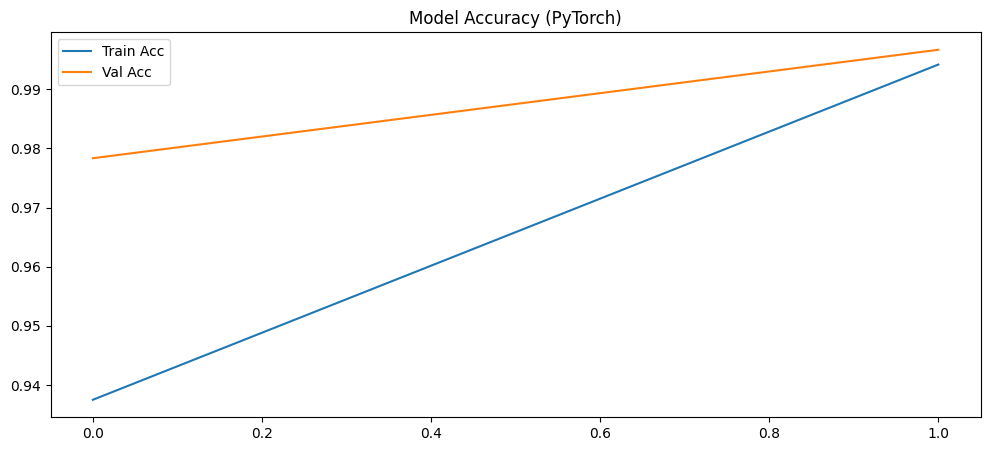

In [35]:
plt.figure(figsize=(12, 5))
plt.plot(acc_history['train'], label='Train Acc')
plt.plot(acc_history['val'], label='Val Acc')
plt.title('Model Accuracy (PyTorch)')
plt.legend()
plt.show()

Now, write the code for the loss plot


### Task: Plot the *Model Loss* from the training history of the model


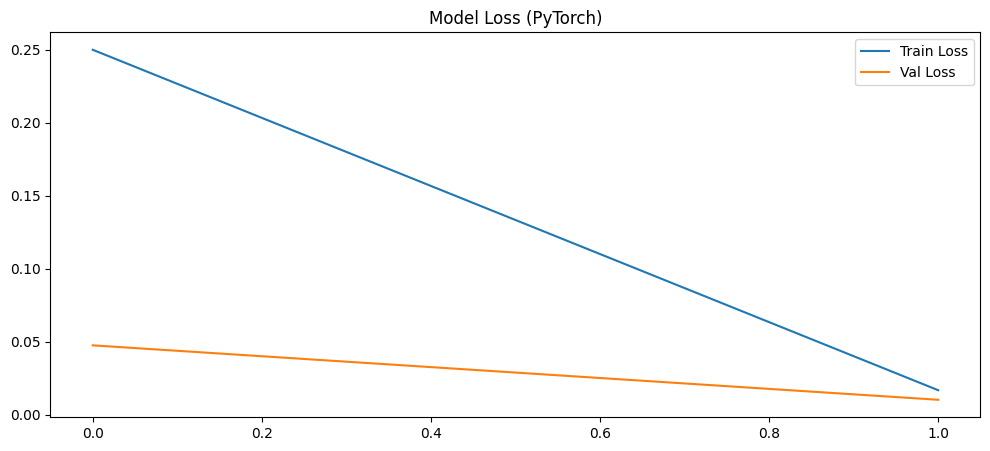

In [36]:
## You can use this cell to type the answer to the question.

plt.figure(figsize=(12, 5))
plt.plot(loss_history['train'], label='Train Loss')
plt.plot(loss_history['val'], label='Val Loss')
plt.title('Model Loss (PyTorch)')
plt.legend()
plt.show()


Double-click **here** for the solution.
<!-- The correct answer is:

plt.figure(figsize=(12, 5))
plt.plot(loss_history['train'], label='Train Loss')
plt.plot(loss_history['val'], label='Val Loss')
plt.title('Model Loss (PyTorch)')
plt.legend()
plt.show()

-->


## Final model evaluation

This cell comprehensively evaluates the best-performing model saved during the training loop. While accuracy provides a high-level view, these metrics provide a deeper insight into the model's behavior.


- **`model.eval()`**: Switches the model to evaluation mode.
- **`with torch.no_grad()`**: Disables gradient computation for efficiency.
- **Collecting Predictions**: The code iterates through the entire validation set to gather all predictions and their corresponding true labels.

- **`accuracy`**: The proportion of correct predictions out of the total predictions.


To evaluate the model, you have to get the predictions for the images.


### Task: For the images from `val_loader`, get a list of :
<p></p>

<p></p>
 
**1.** all predictions `all_preds`
 
**2.** the ground truth labels `all_labels` 

For the predictions, you will have to move the data to the CPU using `predictions.cpu()`


In [37]:
## You can use this cell to type the answer to the question.
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy().flatten())
        all_labels.extend(labels.numpy())


Double-click **here** for the solution.
<!-- The correct answer is:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy().flatten())
        all_labels.extend(labels.numpy())
-->


### Get the accuracy of the plot

**`accuracy`** is the proportion of correct predictions out of the total predictions.

You can use `accuracy_score` from `sklearn.metrics` class to calculate the **accuracy_score**


In [38]:
accuracy = accuracy_score(all_labels, all_preds)
print(f"The accuracy of the model is: {accuracy:.4f}")

The accuracy of the model is: 0.9967


## Save and download the notebook for **final project** submission and evaluation

You will need to save and download the completed notebook for final project submission and evaluation. 
<br>For saving and downloading the completed notebook, please follow the steps given below:</br>

<font size = 4>  

1) **Complete** all the tasks and questions given in the notebook.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/nv4jHlPU5_R1q7ZJrZ69eg/DL0321EN-M1L1-Save-IPYNB-Screenshot-1.png" style="width:600px; border:0px solid black;">

2) **Save** the notebook.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9-WPWD4mW1d-RV5Il5otTg/DL0321EN-M1L1-Save-IPYNB-Screenshot-2.png" style="width:600px; border:0px solid black;">

3) Identify and right click on the **correct notebook file** in the left pane.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/RUSRPw7NT6Sof94B7-9naQ/DL0321EN-M1L1-Save-IPYNB-Screenshot-3.png" style="width:600px; border:0px solid black;">

4) Click on **Download**.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/HHry4GT-vhLEcRi1T_LHGg/DL0321EN-M1L1-Save-IPYNB-Screenshot-4.png" style="width:600px; border:0px solid black;">

5) Download and **Save** the Jupyter notebook file on your computer **for final submission**.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/hhsJbxc6R-T8_pXQGjMjvg/DL0321EN-M1L1-Save-IPYNB-Screenshot-5.png" style="width:600px; border:0px solid black;">
  </font>


## Conclusion
Congratulation! You've successfully built, trained, and evaluated a deep learning model for image classification using PyTorch.

In this lab, you coded for:
- **Data loading pipeline:** Implementing ImageDataGenerator for efficient on-the-fly image loading, resizing, normalization, and vital data augmentation.
- **CNN architecture:** Building a multi-layered CNN incorporating Conv2D layers.
- **Model training setup:** Configuring the model’s learning process using the Adam optimizer, BCEWithLogitsLoss, and tracking accuracy and loss metrics.
- **Training process:** Executing the training loop by feeding data in batches and monitoring performance over epochs.
- **Performance visualization:** Plotting accuracy and loss curves to analyze learning progress and detect overfitting.
- **Model evaluation:** Assessing model performance using accuracy_score.


<h2>Author</h2>

[Aman Aggarwal](https://www.linkedin.com/in/aggarwal-aman)

Aman Aggarwal is a PhD working at the intersection of neuroscience, AI, and drug discovery. He specializes in quantitative microscopy and image processing.



<!--

## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2025-07-04  | 1.0  | Aman  |  Created the lab |

-->


© Copyright IBM Corporation. All rights reserved.
